---
---
# **1. Imports**
---
---

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tabulate

---
---
# **2. Configuration**
---
---

In [2]:
# Config
ARTIFACT_DIR = "artifacts_regression"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Models
models = {
    "Linear Regression Tuned": joblib.load("../models/regression/best_lr_pipeline.pkl"),
    "Random Forest Tuned": joblib.load("../models/regression/best_rf_pipeline.pkl"),
    "XGBoost Tuned": joblib.load("../models/regression/best_xgb_pipeline.pkl")
}

# Validation data
df_val = pd.read_csv("../qws1_dataset/validation_data_regression.csv")
target = "WsRF: Web Service Relevancy Function (%)"
X_val = df_val.drop(columns=[target])
y_val = df_val[target]

---
---
# **3. Plotting**
---
---

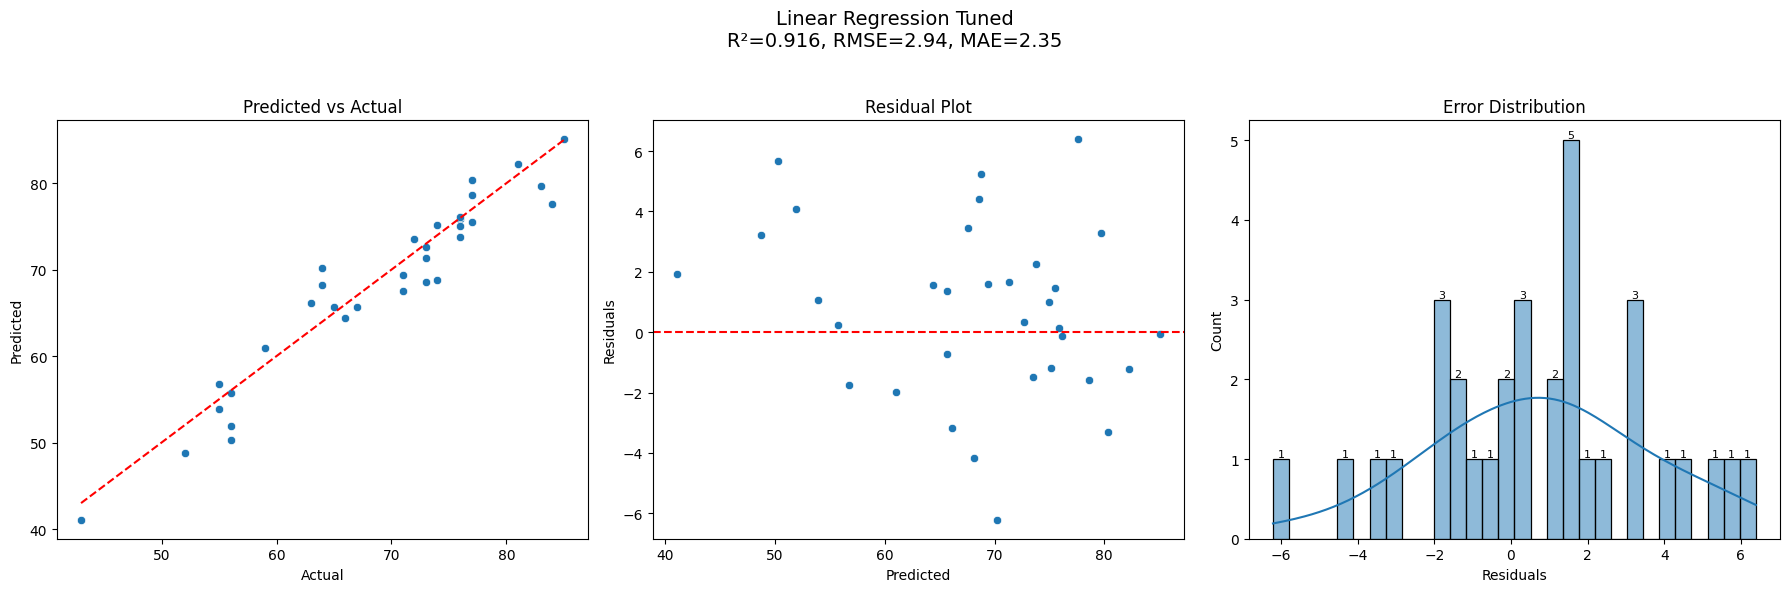

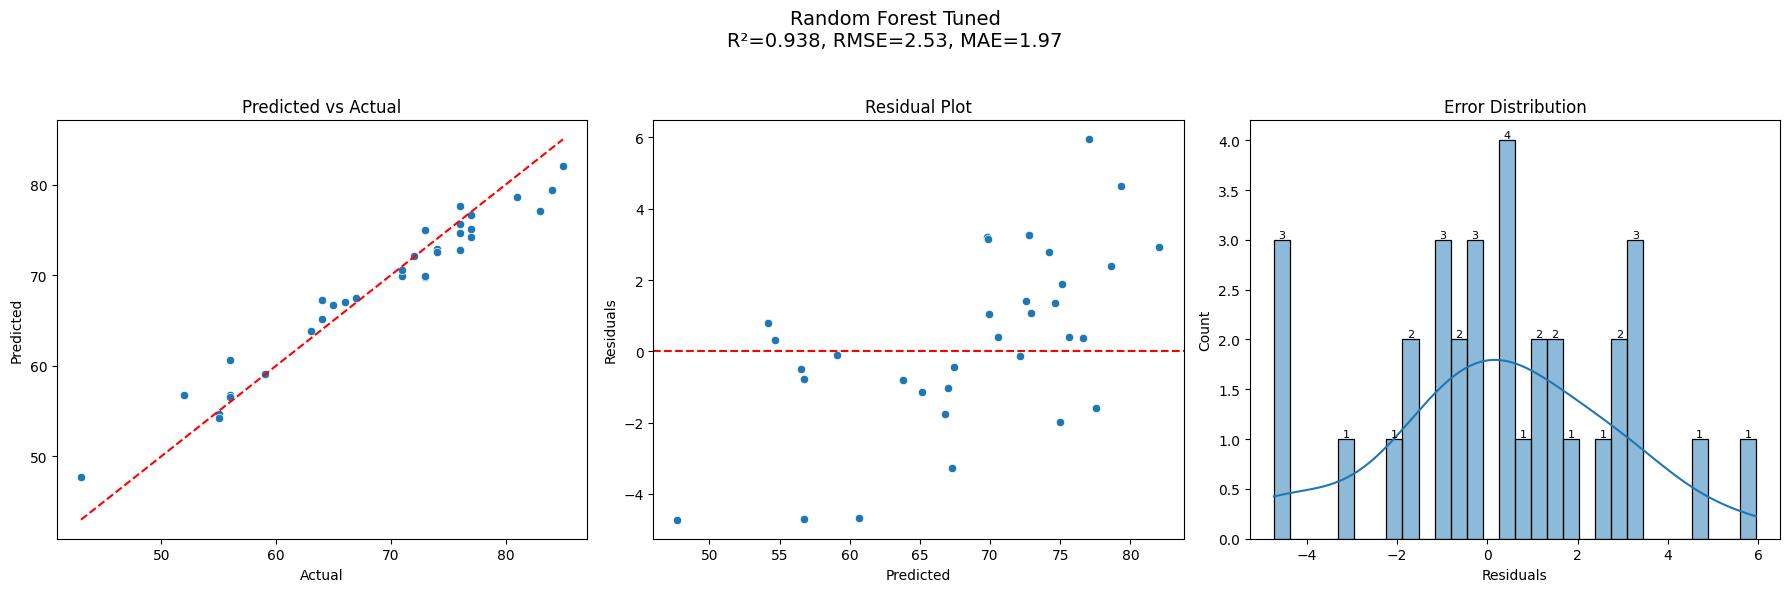

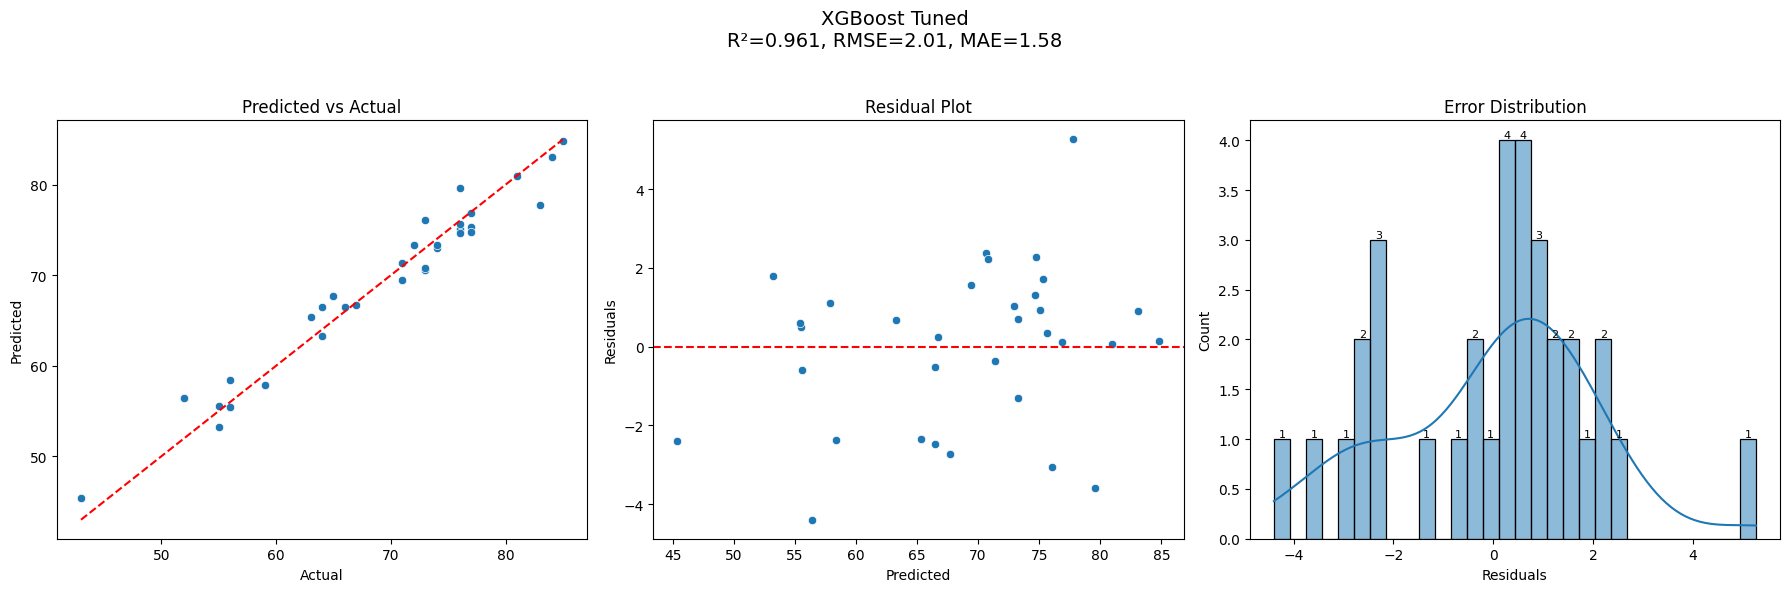

In [3]:
for name, model in models.items():
    y_pred = model.predict(X_val)
    residuals = y_val - y_pred

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Predicted vs Actual
    sns.scatterplot(x=y_val, y=y_pred, ax=axes[0])
    axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    axes[0].set_title("Predicted vs Actual")
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")

    # Residual Plot
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_title("Residual Plot")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Residuals")

    # Error Distribution
    hist = sns.histplot(residuals, bins=30, kde=True, ax=axes[2])
    axes[2].set_title("Error Distribution")
    axes[2].set_xlabel("Residuals")

    for patch in hist.patches:
        height = patch.get_height()
        if height > 0:
            axes[2].text(
                patch.get_x() + patch.get_width() / 2,
                height,
                f"{int(height)}",
                ha="center", va="bottom", fontsize=8, color="black"
            )

    fig.suptitle(f"{name}\nR²={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}", fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{ARTIFACT_DIR}/{name}_plots.png")
    plt.show()


1. Linear Regression Tuned: 
    - Predicted vs Actual plot
        - Points are close to the diagonal red line, indicating good alignment between predictions and actual values.
        - $R^2$ = 0.916 -> The model explains 91.6% of variance.
        - Slight spread at higher values suggests minor under/over-prediction at extremes.
    - Residual Plot
        - Residuals are scattered around zero without a clear pattern, no strong heteroscedasticity.
        - However, some residuals reach ±6, indicating occasional large errors.
    - Error Distribution plot
        - Histogram is roughly centered around zero, but slightly skewed to the positive side.
        - Most residuals fall between -4 and +4, with a few outliers.
        - Shape is close to normal.

2. Random Forest Tuned:
    - Predicted vs Actual plot
        - Points are tighter around the diagonal compared to Linear Regression.
        - $R^2$ = 0.938, RMSE and MAE are lower -> better performance than Linear Regression.
        - Slight clustering near higher actual values, but overall strong fit.
    - Residual Plot
        - Residuals are more evenly distributed than Linear Regression, but some negative residuals at lower predicted values.
        - No obvious trend, which is good.
    - Error Distribution plot 
        - Centered near zero, slightly narrower spread than Linear Regression.
        - Fewer extreme residuals -> Random Forest handles variability better.

3. XGBoost Tuned:
    - Predicted vs Actual plot
        - Points almost perfectly align with the diagonal.
        - $R^2$ = 0.961, RMSE = 2.01, MAE = 1.58 -> best performance among all models.
        - Very tight clustering, minimal deviation.
    - Residual Plot
        - Residuals are small and evenly scattered around zero.
        - No visible pattern.
    - Error Distribution plot:
        - Very narrow spread, most residuals between -3 and +3.
        - Almost symmetric around zero → strong indication of unbiased predictions.

---
---
# **4. Drift Checks**
---
---

In [4]:
# Load training data
path = '../qws1_dataset/training_data_regression.csv'
df_train = pd.read_csv(path)

# Define columns
train_col = ['Response Time', 'Availability', 'Throughput', 'Successability',
             'Reliability', 'Compliance', 'Documentation']
target_col = 'WsRF: Web Service Relevancy Function (%)'

# Split features and target
X_train = df_train[train_col]
y_train = df_train[target_col]

Information:
- Training data 254 rows, validation data 33 rows
- PSI thresholds:
    - < 0.1 -> No drift
    - 0.1 to 0.25 -> Moderate drift
    - less than 0.25 -> Significant drift

In [ ]:
# 4. Drift Checks
def calculate_psi(expected, actual, buckets=10):
    """Calculate Population Stability Index (PSI)"""
    breakpoints = np.linspace(min(expected.min(), actual.min()), max(expected.max(), actual.max()), buckets + 1)
    expected_counts = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_counts = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    # Avoid division by zero
    expected_counts = np.where(expected_counts == 0, 1e-6, expected_counts)
    actual_counts = np.where(actual_counts == 0, 1e-6, actual_counts)

    psi_values = (actual_counts - expected_counts) * np.log(actual_counts / expected_counts)
    return np.sum(psi_values)

drift_results = []

for col in X_train.columns:
    psi = calculate_psi(X_train[col], X_val[col])
    ks_stat, ks_p = ks_2samp(X_train[col], X_val[col])

    # PSI
    if psi < 0.1:
        psi_label = "No drift"
    elif psi < 0.25:
        psi_label = "Moderate drift"
    else:
        psi_label = "Significant drift"

    drift_results.append({
        'Feature': col,
        'PSI': psi,
        'PSI_Interpretation': psi_label,
        'KS_Statistic': ks_stat,
        'KS_p_value': ks_p
    })

# DataFrame and sort
df_drift = pd.DataFrame(drift_results).sort_values(by='PSI', ascending=False)

In [7]:
# Save drift results
df_drift.to_csv(f"{ARTIFACT_DIR}/drift_results.csv", index=False)
print("Drift results saved:", f"{ARTIFACT_DIR}/drift_results.csv")
df_drift

Drift results saved: artifacts_regression/drift_results.csv


,Feature,PSI,PSI_Interpretation,KS_Statistic,KS_p_value
4,Reliability,1.905166,Significant drift,0.122644,0.721870
2,Throughput,0.956470,Significant drift,0.068838,0.997119
3,Successability,0.940700,Significant drift,0.107969,0.845488
1,Availability,0.598314,Significant drift,0.063231,0.999162
6,Documentation,0.440201,Significant drift,0.206872,0.140600
0,Response Time,0.190055,Moderate drift,0.146266,0.508647
5,Compliance,0.066937,No drift,0.109640,0.832711


| | Feature | PSI | PSI_Interpretation | KS_Statistic | KS_p_values|
|---|---|---|---|---|---|
|4|Reliability| 1.9051663090330935| Significant drift| 0.12264376043903603| 0.7218697917931856|
|2|Throughput|0.9564699672042045|Significant drift|0.0688379861608208|0.9971193584934738|
|3| Successability|0.9406997529203982|Significant drift|0.10796945836315915|0.8454877830265335|
|1| Availability|0.598313821831578|Significant drift|0.0632307325220711|0.9991620200939377|
|6|Documentation|0.4402010701314691|Significant drift|0.20687186828919113|0.14060026660606562|
|0| Response Time| 0.19005495841958076|Moderate drift|0.14626580768313052|0.5086471100503902|
|5| Compliance|0.06693674612053797|No drift|0.1096397041278931|0.8327112309513028|

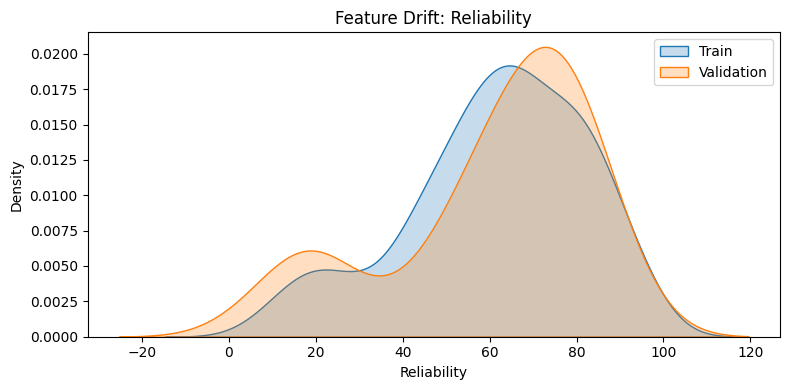

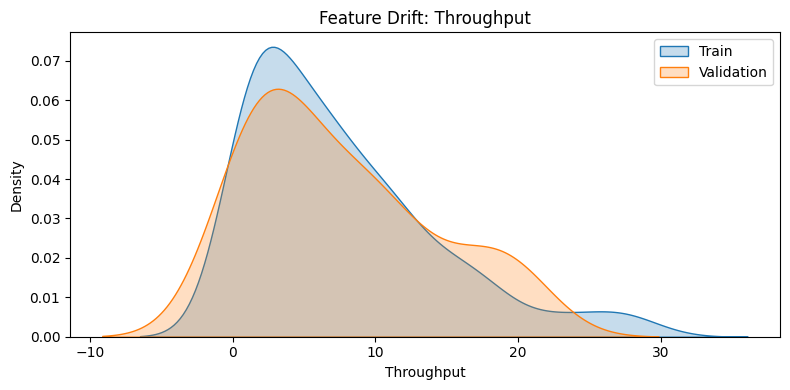

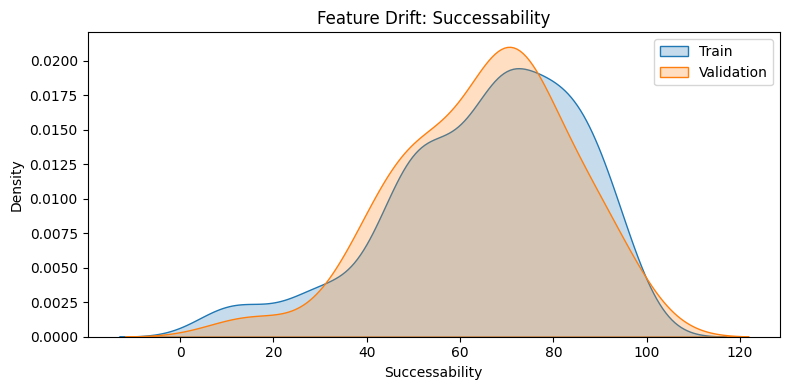

In [8]:
# Top 3 drifted features
top_features = df_drift['Feature'].head(3)
for col in top_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X_train[col], label='Train', fill=True)
    sns.kdeplot(X_val[col], label='Validation', fill=True)
    plt.title(f"Feature Drift: {col}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{ARTIFACT_DIR}/drift_{col}.png")
    plt.show()

1. Reliability
- Validation distribution is shifted to the right compared to training.
- Indicates higher reliability values in validation data.
- PSI confirms this as the most drifted feature.

2. Throughput
- Validation curve shows heavier tail on the right.
- Suggests more high-throughput observations in validation compared to training.
- This could affect model predictions if throughput strongly influences the target.

3. Successability
- Validation distribution slightly shifted right.
- Indicates improved successability in validation data.
- Drift is significant but less extreme than Reliability


---
---
# **5. Summary**
---
---

In [17]:
# 5. Summary Report
summary_md = "# Regression Model Evaluation Report\n\n"

# Metrics
summary_md += "## Metrics\n"
summary_md += pd.read_csv("backtest_summary.csv").to_markdown() + "\n\n"

# Drift Analysis
summary_md += "## Drift Analysis\n"
summary_md += df_drift.to_markdown() + "\n\n"

# Interpretation
summary_md += "### Drift Interpretation\n"
summary_md += """
- **PSI > 0.25** indicates significant drift. Five features show major drift: Reliability, Throughput, Successability, Availability, and Documentation.
- Response Time shows moderate drift, while Compliance remains stable.
- KS p-values > 0.05 suggest shape differences are not statistically significant, but PSI captures magnitude shifts.
\n"""

# Drift plots
summary_md += "## Drift Plots (Top 3 Features)\n"
for col in df_drift['Feature'].head(3):
    summary_md += f"![Drift for {col}]({ARTIFACT_DIR}/rmance plots)"
summary_md += "## Model Performance Plots\n"
for name in models.keys():
    summary_md += f"!{name} Pred vs Actual\n"

# Write to file
with open(os.path.join(ARTIFACT_DIR, "summary_report.md"), "w") as f:
    f.write(summary_md)

print("Sections 3-5 completed. Artifacts saved in:", ARTIFACT_DIR)

Sections 3-5 completed. Artifacts saved in: artifacts_regression
